In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Function
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Prep Training Data (Breast Cancer Wisconsin)

#Load the data file
df = pd.read_csv("/content/FLIQ-Virtual-Hackathon/Sample Code/data/wdbc.data", header=None)

#Assign column names
columns = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
df.columns = columns

#Drop the ID column
df = df.drop(columns=['id'])

#Encode diagnosis: M = 1, B = 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

#Convert to numpy arrays
X = df.drop(columns=['diagnosis']).values.astype(np.float32)
Y = df['diagnosis'].values.astype(np.float32).reshape(-1, 1)

#Normalize features manually (z-score)
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

# --- Feature reduction: keep first 4 principal components (retain >90% var) ---
X_pca = PCA(n_components=4).fit_transform(X)

#Convert to torch tensors (use PCA-reduced features)
X_tensor = torch.tensor(X_pca, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

#Manual train/test split (80/20)
num_samples = X_tensor.shape[0]
indices = torch.randperm(num_samples)

split_idx = int(num_samples * 0.8)
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

X_train = X_tensor[train_indices].to(device)
Y_train = Y_tensor[train_indices].to(device)
X_test = X_tensor[test_indices].to(device)
Y_test = Y_tensor[test_indices].to(device)

# ----- 2-qubit VQA (data-reuploading, 3 layers, 12 params) -----
n_qubits = 2
param_count = 12  # 2 qubits × 2 params (Ry,Rz) × 3 layers
params = ParameterVector('theta', length=param_count)

# Helper to add an entangling ring
_def_entangle = lambda qc: qc.cx(0, 1)

def create_vqa_circuit(input_data, weights):
    """2-qubit, 3-layer data-reuploading circuit."""
    qc = QuantumCircuit(n_qubits)
    idx = 0
    for layer in range(3):
        # encode data
        qc.ry(float(input_data[0]) * (layer+1), 0)
        qc.ry(float(input_data[1]) * (layer+1), 1)
        _def_entangle(qc)
        # trainable block
        for q in range(n_qubits):
            qc.ry(float(weights[idx]), q); idx += 1
            qc.rz(float(weights[idx]), q); idx += 1
        _def_entangle(qc)
    return qc

#Qiskit StatevectorEstimator primitive
estimator = StatevectorEstimator()

# Observables: Z expectation on each qubit
observables = [SparsePauliOp("ZI"), SparsePauliOp("IZ")]

#PyTorch Custom Autograd Function For VQA Layer
class VQALayerFunction(Function):
    @staticmethod
    def forward(ctx, input_tensor, weights):
        # input_tensor shape (4,), weights shape (12,)
        input_vals  = input_tensor.cpu().detach().numpy()
        weight_vals = weights.cpu().detach().numpy()
        ctx.save_for_backward(input_tensor, weights)

        qc = create_vqa_circuit(input_vals, weight_vals)
        circuits = [(qc, obs) for obs in observables]
        res = estimator.run(circuits).result()
        expvals = np.array([r.data.evs for r in res])  # shape (4,)
        return torch.tensor(expvals, dtype=torch.float32).to(input_tensor.device)

    @staticmethod
    def backward(ctx, grad_output):
        input_tensor, weights = ctx.saved_tensors
        x      = input_tensor.cpu().detach().numpy()
        theta  = weights.cpu().detach().numpy()
        shift  = np.pi/2
        # gradients wrt weights
        grad_w = []
        for k in range(len(theta)):
            theta_p, theta_m = theta.copy(), theta.copy()
            theta_p[k] += shift; theta_m[k] -= shift
            qc_p = create_vqa_circuit(x, theta_p)
            qc_m = create_vqa_circuit(x, theta_m)
            res_p = estimator.run([(qc_p, obs) for obs in observables]).result()
            res_m = estimator.run([(qc_m, obs) for obs in observables]).result()
            grad_w.append(0.5 * (np.array([r.data.evs for r in res_p]) -
                                  np.array([r.data.evs for r in res_m])))
        grad_w = torch.tensor(grad_w, dtype=torch.float32).to(grad_output.device)  # (P,2)
        weight_grad = torch.mv(grad_w, grad_output.view(-1))  # (P,)

        # gradients wrt inputs (allow classical NN to train)
        grad_x = []
        for j in range(len(x)):
            x_p, x_m = x.copy(), x.copy()
            x_p[j] += shift; x_m[j] -= shift
            qc_p = create_vqa_circuit(x_p, theta)
            qc_m = create_vqa_circuit(x_m, theta)
            res_p = estimator.run([(qc_p, obs) for obs in observables]).result()
            res_m = estimator.run([(qc_m, obs) for obs in observables]).result()
            grad_x.append(0.5 * (np.array([r.data.evs for r in res_p]) -
                                  np.array([r.data.evs for r in res_m])))
        grad_x = torch.tensor(grad_x, dtype=torch.float32).to(grad_output.device)  # (2,2)
        input_grad = torch.mv(grad_x, grad_output.view(-1))  # (features,)

        return input_grad, weight_grad

#Quantum Layer as PyTorch Module
class VQALayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(param_count, device=device))

    def forward(self, x):
        # x shape (batch,2)
        outputs = [VQALayerFunction.apply(x[i], self.weights) for i in range(x.size(0))]
        return torch.stack(outputs)  # (batch,2)

#Full Hybrid Model
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.classical = nn.Sequential(
            nn.Linear(X_tensor.shape[1], 16),
            nn.ReLU(),
            nn.Linear(16, 2),  # output matches qubit count
            nn.Tanh()
        )
        self.quantum = VQALayer()
        self.output = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.classical(x)
        x = self.quantum(x)
        x = self.output(x)
        return x

model = HybridModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.BCELoss()

#Training Loop
for epoch in range(50):
    optimizer.zero_grad()
    preds = model(X_train)
    loss = loss_fn(preds, Y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        acc = ((preds > 0.5).float() == Y_train).float().mean()
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Accuracy: {acc.item()*100:.2f}%")

#Implement Testing Loop:
with torch.no_grad():
    test_preds = model(X_test)
    test_labels_on_device = (test_preds > 0.5).float()
    test_acc = (test_labels_on_device == Y_test).float().mean().item()
    print("\nTest Accuracy: {:.2f}%".format(test_acc*100))
    print("\nClassification Report:\n", classification_report(Y_test.cpu().numpy(), test_labels_on_device.cpu().numpy()))
    print("Confusion Matrix:\n", confusion_matrix(Y_test.cpu().numpy(), test_labels_on_device.cpu().numpy()))

# Save the trained model
model_save_path = "model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"\nTrained model saved to: {model_save_path}")



Using device: cpu


<ipython-input-4-6ef0828f119a>:123: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  grad_w = torch.tensor(grad_w, dtype=torch.float32).to(grad_output.device)  # (P,2)


Epoch 1 | Loss: 0.7179 | Accuracy: 36.48%
Epoch 2 | Loss: 0.7172 | Accuracy: 36.48%
Epoch 3 | Loss: 0.7165 | Accuracy: 36.48%
Epoch 4 | Loss: 0.7158 | Accuracy: 36.48%
Epoch 5 | Loss: 0.7151 | Accuracy: 36.48%
Epoch 6 | Loss: 0.7143 | Accuracy: 36.48%
Epoch 7 | Loss: 0.7136 | Accuracy: 36.48%
Epoch 8 | Loss: 0.7128 | Accuracy: 36.48%
Epoch 9 | Loss: 0.7120 | Accuracy: 36.48%
Epoch 10 | Loss: 0.7112 | Accuracy: 36.48%
Epoch 11 | Loss: 0.7103 | Accuracy: 36.48%
Epoch 12 | Loss: 0.7094 | Accuracy: 36.48%
Epoch 13 | Loss: 0.7086 | Accuracy: 36.48%
Epoch 14 | Loss: 0.7076 | Accuracy: 36.48%
Epoch 15 | Loss: 0.7067 | Accuracy: 36.48%
Epoch 16 | Loss: 0.7058 | Accuracy: 36.48%
Epoch 17 | Loss: 0.7048 | Accuracy: 36.48%
Epoch 18 | Loss: 0.7038 | Accuracy: 36.48%
Epoch 19 | Loss: 0.7028 | Accuracy: 36.48%
Epoch 20 | Loss: 0.7018 | Accuracy: 36.48%
Epoch 21 | Loss: 0.7008 | Accuracy: 36.48%
Epoch 22 | Loss: 0.6998 | Accuracy: 36.70%
Epoch 23 | Loss: 0.6989 | Accuracy: 36.26%
Epoch 24 | Loss: 0.6

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Function
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Prep Training Data (Breast Cancer Wisconsin)

#Load the data file
df = pd.read_csv("/content/FLIQ-Virtual-Hackathon/Sample Code/data/wdbc.data", header=None)

#Assign column names
columns = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
df.columns = columns

#Drop the ID column
df = df.drop(columns=['id'])

#Encode diagnosis: M = 1, B = 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

#Convert to numpy arrays
X = df.drop(columns=['diagnosis']).values.astype(np.float32)
Y = df['diagnosis'].values.astype(np.float32).reshape(-1, 1)

#Normalize features manually (z-score)
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

# --- Feature reduction: keep first 4 principal components (retain >90% var) ---
X_pca = PCA(n_components=4).fit_transform(X)

#Convert to torch tensors (use PCA-reduced features)
X_tensor = torch.tensor(X_pca, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

#Manual train/test split (80/20)
num_samples = X_tensor.shape[0]
indices = torch.randperm(num_samples)

split_idx = int(num_samples * 0.8)
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

X_train = X_tensor[train_indices].to(device)
Y_train = Y_tensor[train_indices].to(device)
X_test = X_tensor[test_indices].to(device)
Y_test = Y_tensor[test_indices].to(device)

# ----- 2-qubit VQA (data-reuploading, 3 layers, 12 params) -----
n_qubits = 2
param_count = 12  # 2 qubits × 2 params (Ry,Rz) × 3 layers
params = ParameterVector('theta', length=param_count)

# Helper to add an entangling ring
_def_entangle = lambda qc: qc.cx(0, 1)

def create_vqa_circuit(input_data, weights):
    """2-qubit, 3-layer data-reuploading circuit."""
    qc = QuantumCircuit(n_qubits)
    idx = 0
    for layer in range(3):
        # encode data
        qc.ry(float(input_data[0]) * (layer+1), 0)
        qc.ry(float(input_data[1]) * (layer+1), 1)
        _def_entangle(qc)
        # trainable block
        for q in range(n_qubits):
            qc.ry(float(weights[idx]), q); idx += 1
            qc.rz(float(weights[idx]), q); idx += 1
        _def_entangle(qc)
    return qc

#Qiskit StatevectorEstimator primitive
estimator = StatevectorEstimator()

# Observables: Z expectation on each qubit
observables = [SparsePauliOp("ZI"), SparsePauliOp("IZ")]

#PyTorch Custom Autograd Function For VQA Layer
class VQALayerFunction(Function):
    @staticmethod
    def forward(ctx, input_tensor, weights):
        # input_tensor shape (4,), weights shape (12,)
        input_vals  = input_tensor.cpu().detach().numpy()
        weight_vals = weights.cpu().detach().numpy()
        ctx.save_for_backward(input_tensor, weights)

        qc = create_vqa_circuit(input_vals, weight_vals)
        circuits = [(qc, obs) for obs in observables]
        res = estimator.run(circuits).result()
        expvals = np.array([r.data.evs for r in res])  # shape (4,)
        return torch.tensor(expvals, dtype=torch.float32).to(input_tensor.device)

    @staticmethod
    def backward(ctx, grad_output):
        input_tensor, weights = ctx.saved_tensors
        x      = input_tensor.cpu().detach().numpy()
        theta  = weights.cpu().detach().numpy()
        shift  = np.pi/2
        # gradients wrt weights
        grad_w = []
        for k in range(len(theta)):
            theta_p, theta_m = theta.copy(), theta.copy()
            theta_p[k] += shift; theta_m[k] -= shift
            qc_p = create_vqa_circuit(x, theta_p)
            qc_m = create_vqa_circuit(x, theta_m)
            res_p = estimator.run([(qc_p, obs) for obs in observables]).result()
            res_m = estimator.run([(qc_m, obs) for obs in observables]).result()
            grad_w.append(0.5 * (np.array([r.data.evs for r in res_p]) -
                                  np.array([r.data.evs for r in res_m])))
        grad_w = torch.tensor(grad_w, dtype=torch.float32).to(grad_output.device)  # (P,2)
        weight_grad = torch.mv(grad_w, grad_output.view(-1))  # (P,)

        # gradients wrt inputs (allow classical NN to train)
        grad_x = []
        for j in range(len(x)):
            x_p, x_m = x.copy(), x.copy()
            x_p[j] += shift; x_m[j] -= shift
            qc_p = create_vqa_circuit(x_p, theta)
            qc_m = create_vqa_circuit(x_m, theta)
            res_p = estimator.run([(qc_p, obs) for obs in observables]).result()
            res_m = estimator.run([(qc_m, obs) for obs in observables]).result()
            grad_x.append(0.5 * (np.array([r.data.evs for r in res_p]) -
                                  np.array([r.data.evs for r in res_m])))
        grad_x = torch.tensor(grad_x, dtype=torch.float32).to(grad_output.device)  # (2,2)
        input_grad = torch.mv(grad_x, grad_output.view(-1))  # (features,)

        return input_grad, weight_grad

#Quantum Layer as PyTorch Module
class VQALayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(param_count, device=device))

    def forward(self, x):
        # x shape (batch,2)
        outputs = [VQALayerFunction.apply(x[i], self.weights) for i in range(x.size(0))]
        return torch.stack(outputs)  # (batch,2)

#Full Hybrid Model
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.classical = nn.Sequential(
            nn.Linear(X_tensor.shape[1], 16),
            nn.ReLU(),
            nn.Linear(16, 2),  # output matches qubit count
            nn.Tanh()
        )
        self.quantum = VQALayer()
        self.output = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.classical(x)
        x = self.quantum(x)
        x = self.output(x)
        return x

model = HybridModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.BCELoss()

#Training Loop
for epoch in range(50):
    optimizer.zero_grad()
    preds = model(X_train)
    loss = loss_fn(preds, Y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        acc = ((preds > 0.5).float() == Y_train).float().mean()
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Accuracy: {acc.item()*100:.2f}%")

#Implement Testing Loop:
with torch.no_grad():
    test_preds = model(X_test)
    test_labels_on_device = (test_preds > 0.5).float()
    test_acc = (test_labels_on_device == Y_test).float().mean().item()
    print("\nTest Accuracy: {:.2f}%".format(test_acc*100))
    print("\nClassification Report:\n", classification_report(Y_test.cpu().numpy(), test_labels_on_device.cpu().numpy()))
    print("Confusion Matrix:\n", confusion_matrix(Y_test.cpu().numpy(), test_labels_on_device.cpu().numpy()))

# Save the trained model
model_save_path = "model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"\nTrained model saved to: {model_save_path}")



Using device: cpu


<ipython-input-4-6ef0828f119a>:123: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  grad_w = torch.tensor(grad_w, dtype=torch.float32).to(grad_output.device)  # (P,2)


Epoch 1 | Loss: 0.7179 | Accuracy: 36.48%
Epoch 2 | Loss: 0.7172 | Accuracy: 36.48%
Epoch 3 | Loss: 0.7165 | Accuracy: 36.48%
Epoch 4 | Loss: 0.7158 | Accuracy: 36.48%
Epoch 5 | Loss: 0.7151 | Accuracy: 36.48%
Epoch 6 | Loss: 0.7143 | Accuracy: 36.48%
Epoch 7 | Loss: 0.7136 | Accuracy: 36.48%
Epoch 8 | Loss: 0.7128 | Accuracy: 36.48%
Epoch 9 | Loss: 0.7120 | Accuracy: 36.48%
Epoch 10 | Loss: 0.7112 | Accuracy: 36.48%
Epoch 11 | Loss: 0.7103 | Accuracy: 36.48%
Epoch 12 | Loss: 0.7094 | Accuracy: 36.48%
Epoch 13 | Loss: 0.7086 | Accuracy: 36.48%
Epoch 14 | Loss: 0.7076 | Accuracy: 36.48%
Epoch 15 | Loss: 0.7067 | Accuracy: 36.48%
Epoch 16 | Loss: 0.7058 | Accuracy: 36.48%
Epoch 17 | Loss: 0.7048 | Accuracy: 36.48%
Epoch 18 | Loss: 0.7038 | Accuracy: 36.48%
Epoch 19 | Loss: 0.7028 | Accuracy: 36.48%
Epoch 20 | Loss: 0.7018 | Accuracy: 36.48%
Epoch 21 | Loss: 0.7008 | Accuracy: 36.48%
Epoch 22 | Loss: 0.6998 | Accuracy: 36.70%
Epoch 23 | Loss: 0.6989 | Accuracy: 36.26%
Epoch 24 | Loss: 0.6

In [ ]:
!git clone https://github.com/UN-ICC/FLIQ-Virtual-Hackathon.git

Cloning into 'FLIQ-Virtual-Hackathon'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 66 (delta 4), reused 1 (delta 1), pack-reused 58 (from 1)
Receiving objects: 100% (66/66), 1.00 MiB | 4.41 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
# !pip install qiskit torch numpy pandas

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

# ─── read the CSV in the repo ───────────────────────────
cols = ['id','diagnosis'] + [f'f{i}' for i in range(1,31)]
df   = pd.read_csv('/content/FLIQ-Virtual-Hackathon/Sample Code/data/wdbc.data',
                   header=None, names=cols)

# map diagnosis to integer  (B=0, M=1) but keep the char column for plots
df['label'] = df['diagnosis'].map({'B':0, 'M':1})
df = df.drop('id', axis=1)
print(df.shape)              # (569, 32)

(569, 32)


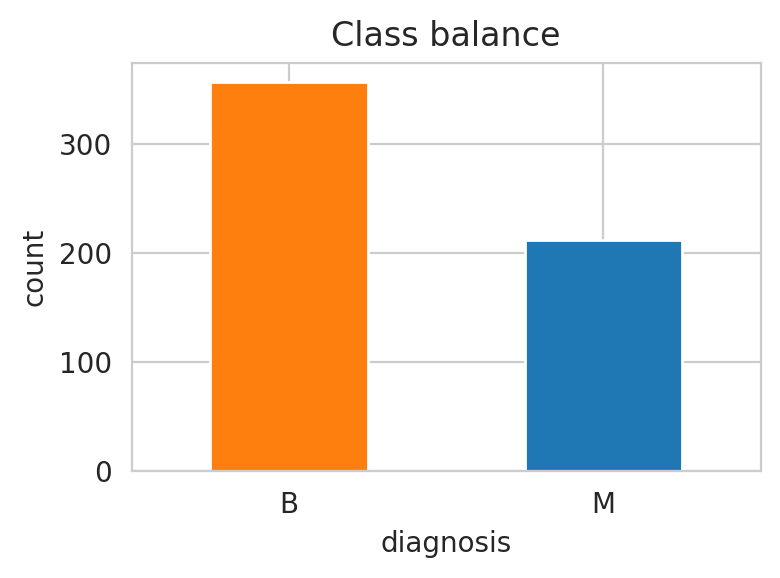

diagnosis
B    357
M    212
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(4,3))
df.diagnosis.value_counts().plot(kind='bar', color=['tab:orange','tab:blue'])
plt.title('Class balance'); plt.ylabel('count'); plt.xticks(rotation=0);
plt.tight_layout(); plt.show()

print(df['diagnosis'].value_counts())

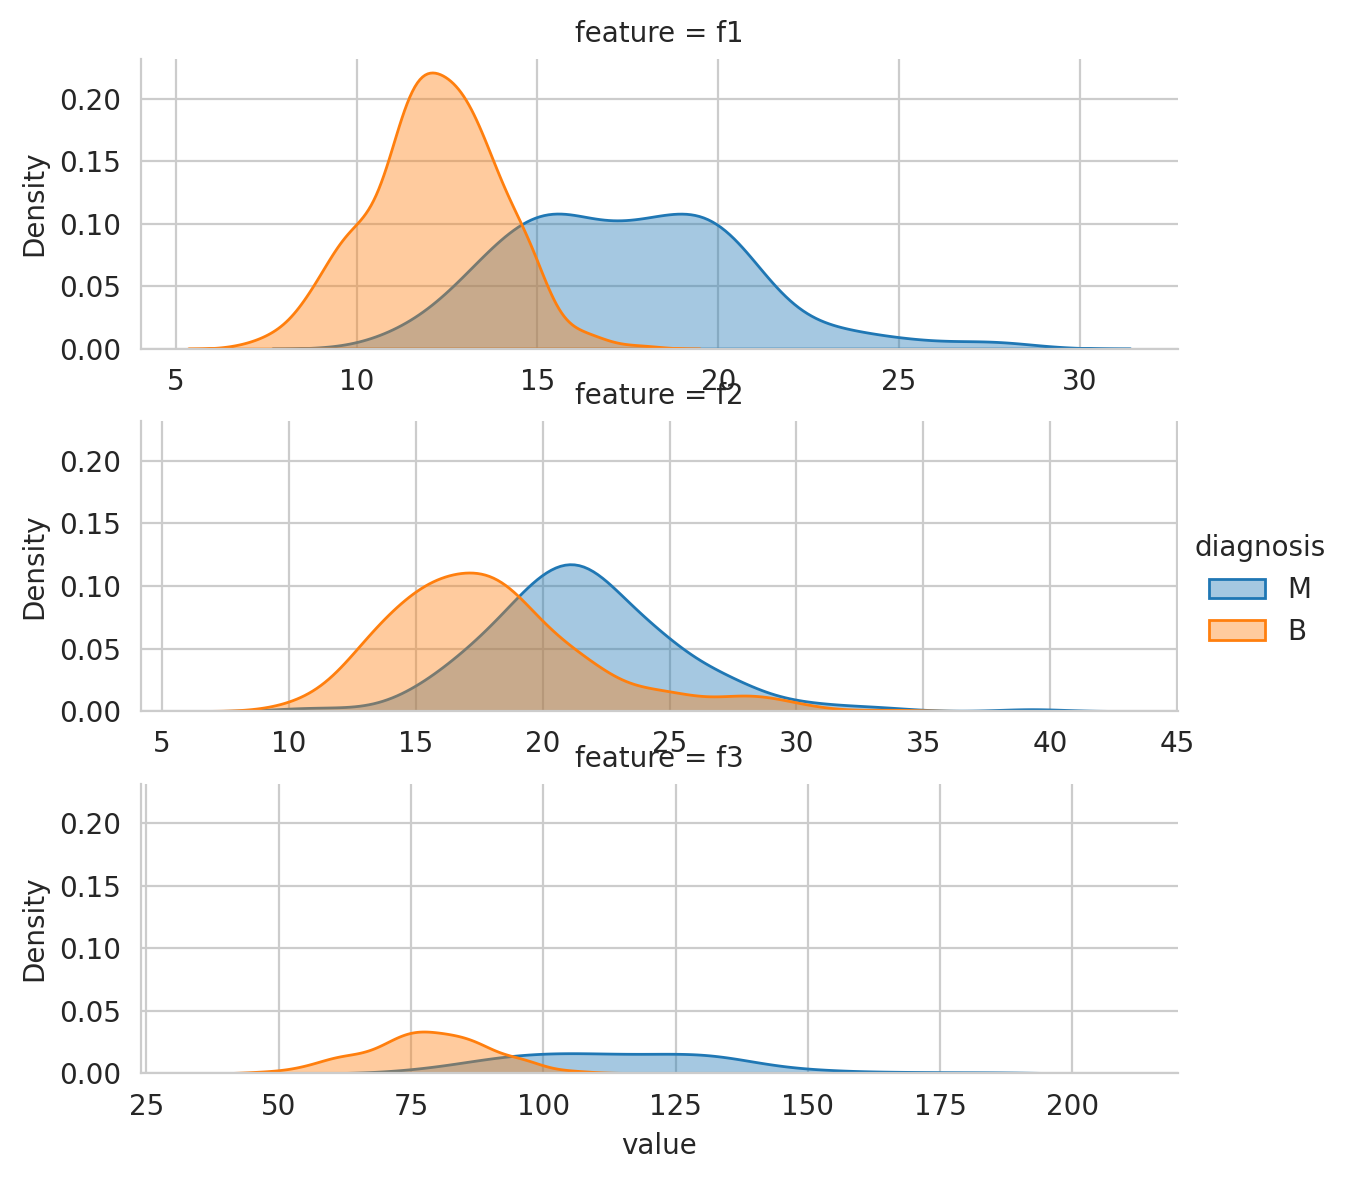

In [ ]:
feat_subset = ['f1','f2','f3']          # radius_mean, texture_mean, perimeter_mean
melted = df.melt(id_vars='diagnosis', value_vars=feat_subset,
                 var_name='feature', value_name='value')

g = sns.FacetGrid(melted, row='feature', hue='diagnosis',
                  sharex=False, height=2, aspect=3, palette=['tab:blue','tab:orange'])
g.map(sns.kdeplot, 'value', fill=True, alpha=.4).add_legend()
g.fig.subplots_adjust(hspace=0.25)
plt.show()

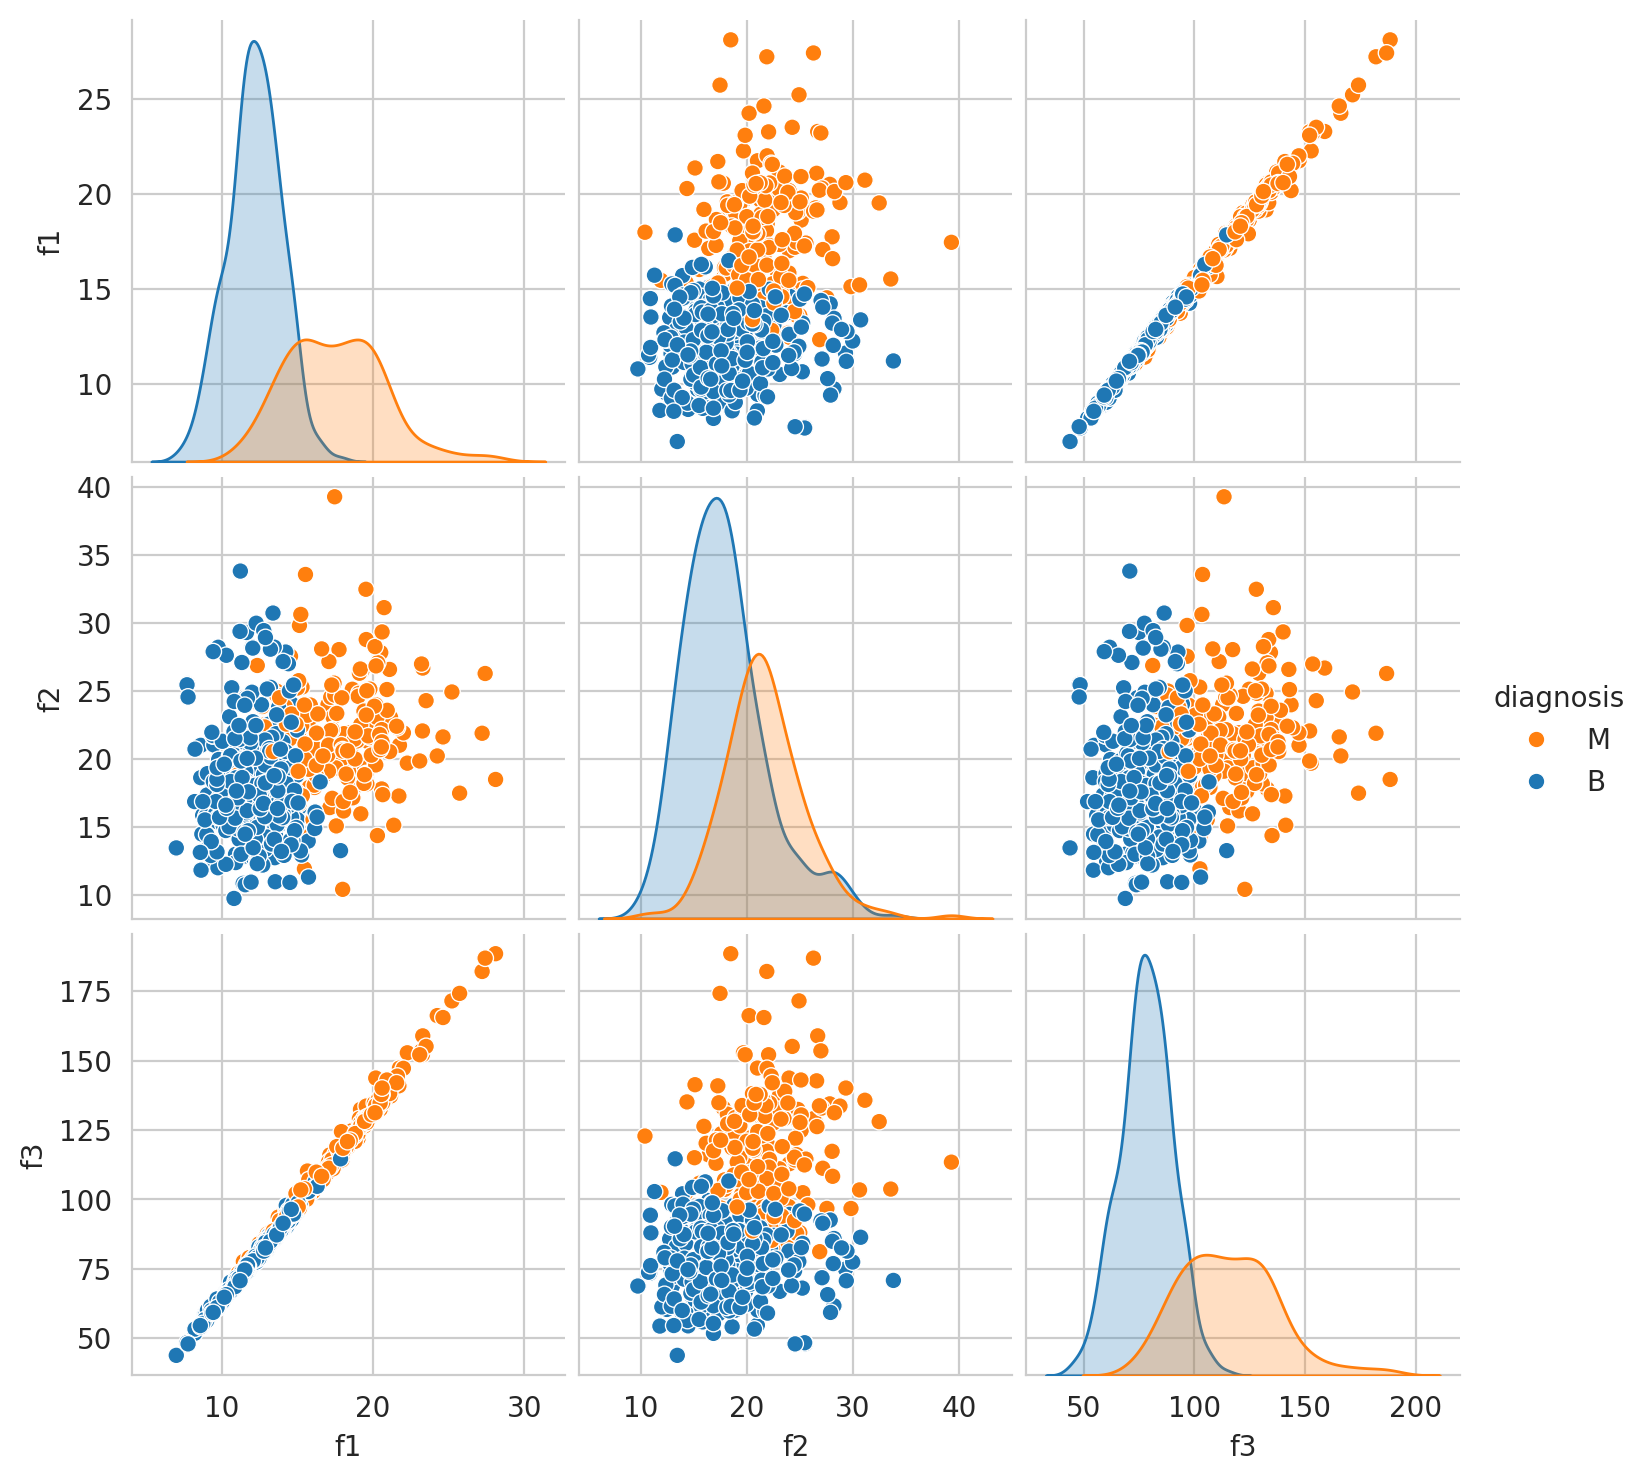

In [ ]:
sns.pairplot(df[['diagnosis','f1','f2','f3']], hue='diagnosis',
             palette=['tab:orange','tab:blue'], diag_kind='kde')
plt.show()

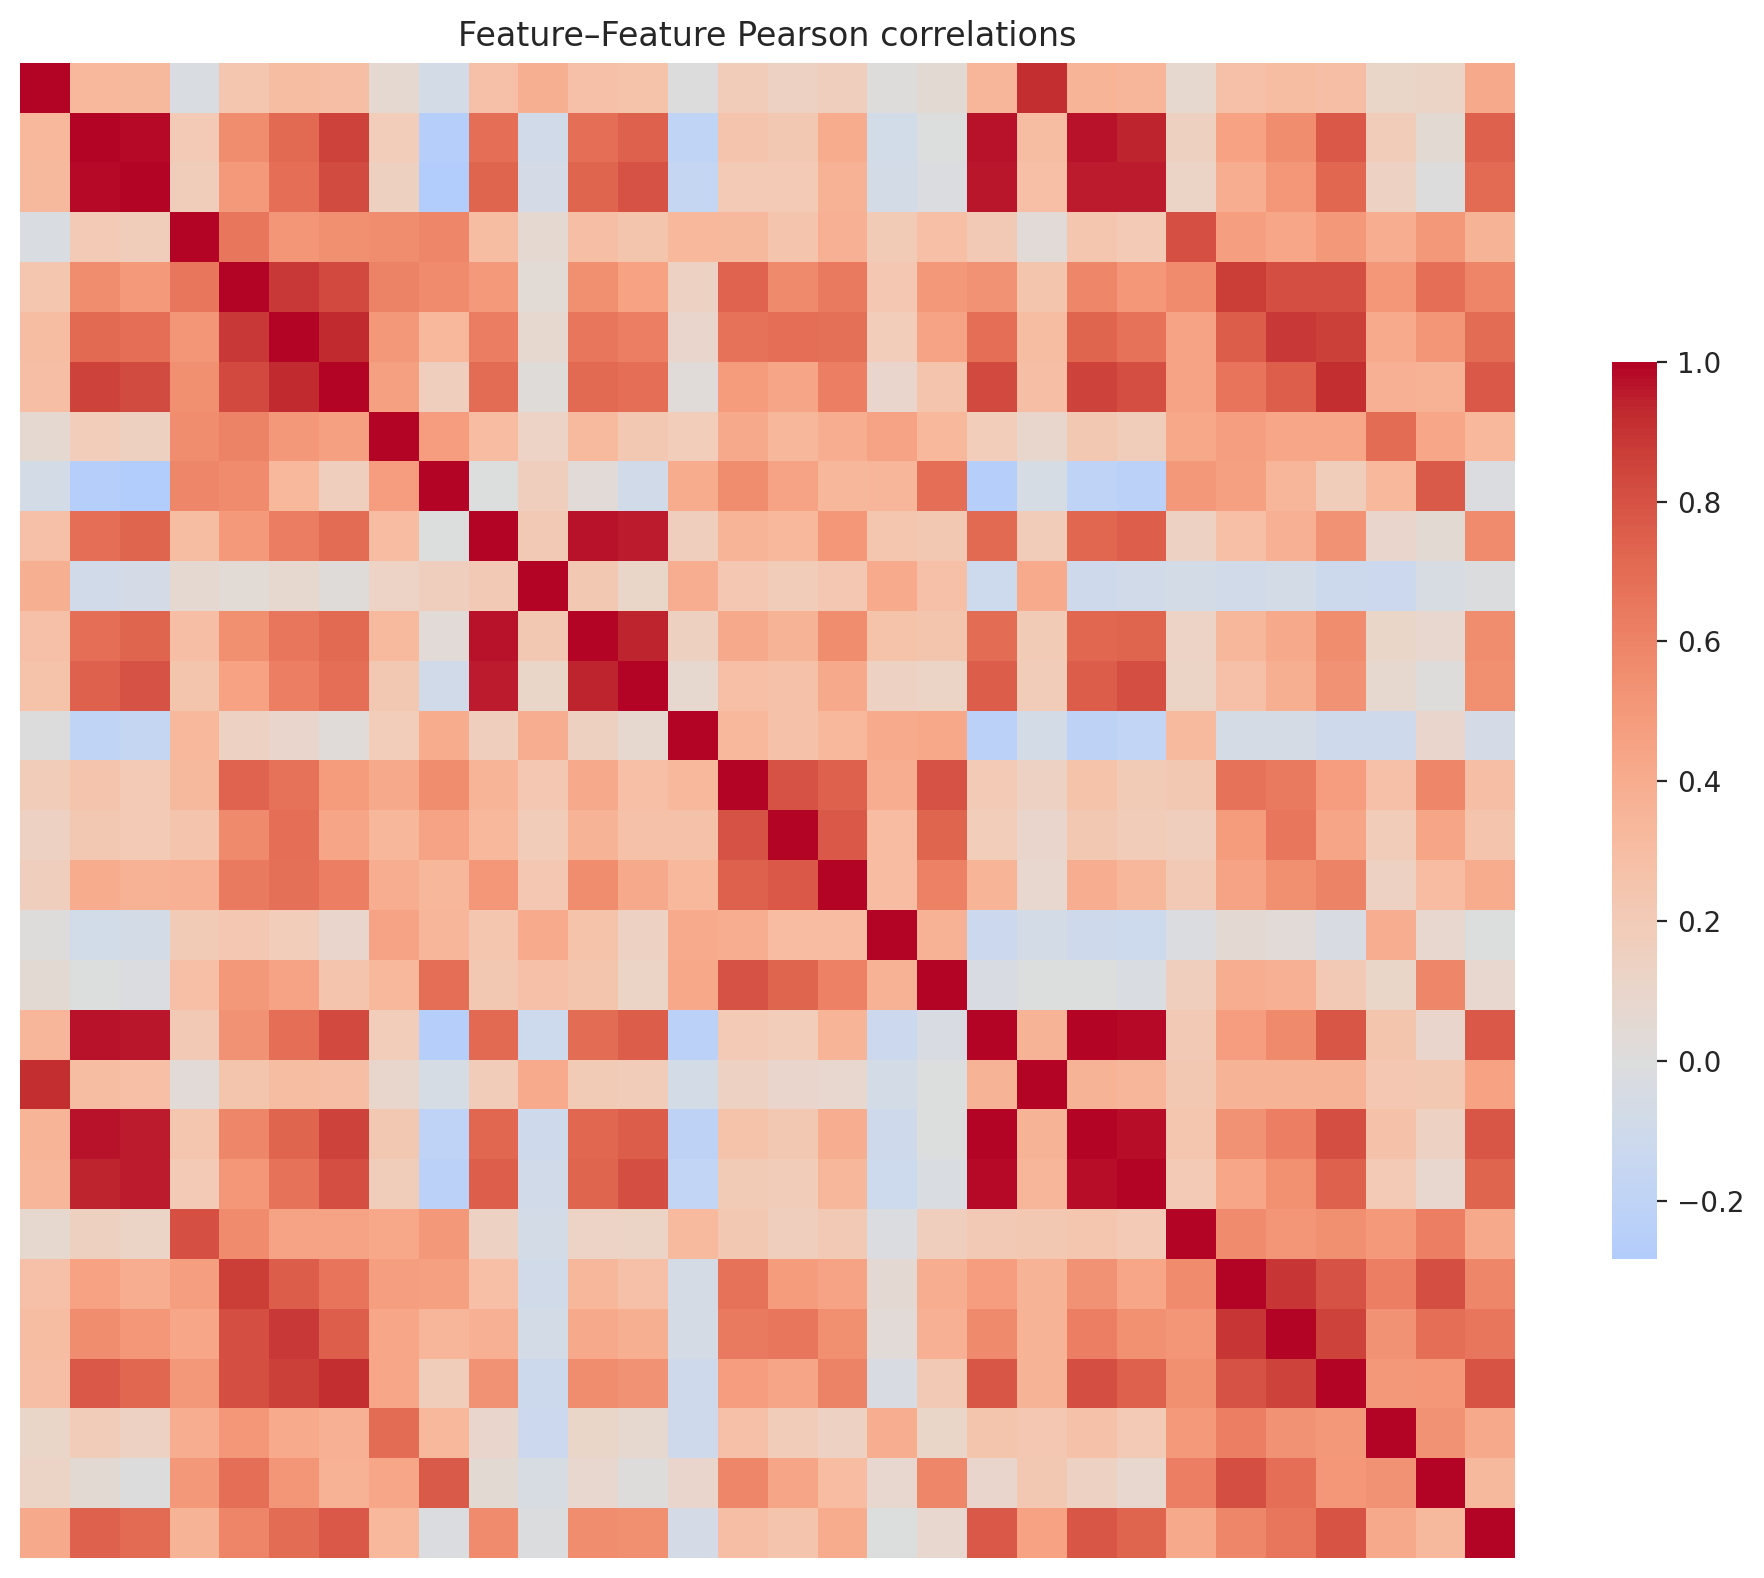

In [ ]:
plt.figure(figsize=(10,8))
corr = df.iloc[:,2:32].corr()          # skip id, diagnosis
sns.heatmap(corr, cmap='coolwarm', center=0, square=True,
            cbar_kws={'shrink':.6}, xticklabels=False, yticklabels=False)
plt.title('Feature–Feature Pearson correlations')
plt.tight_layout(); plt.show()

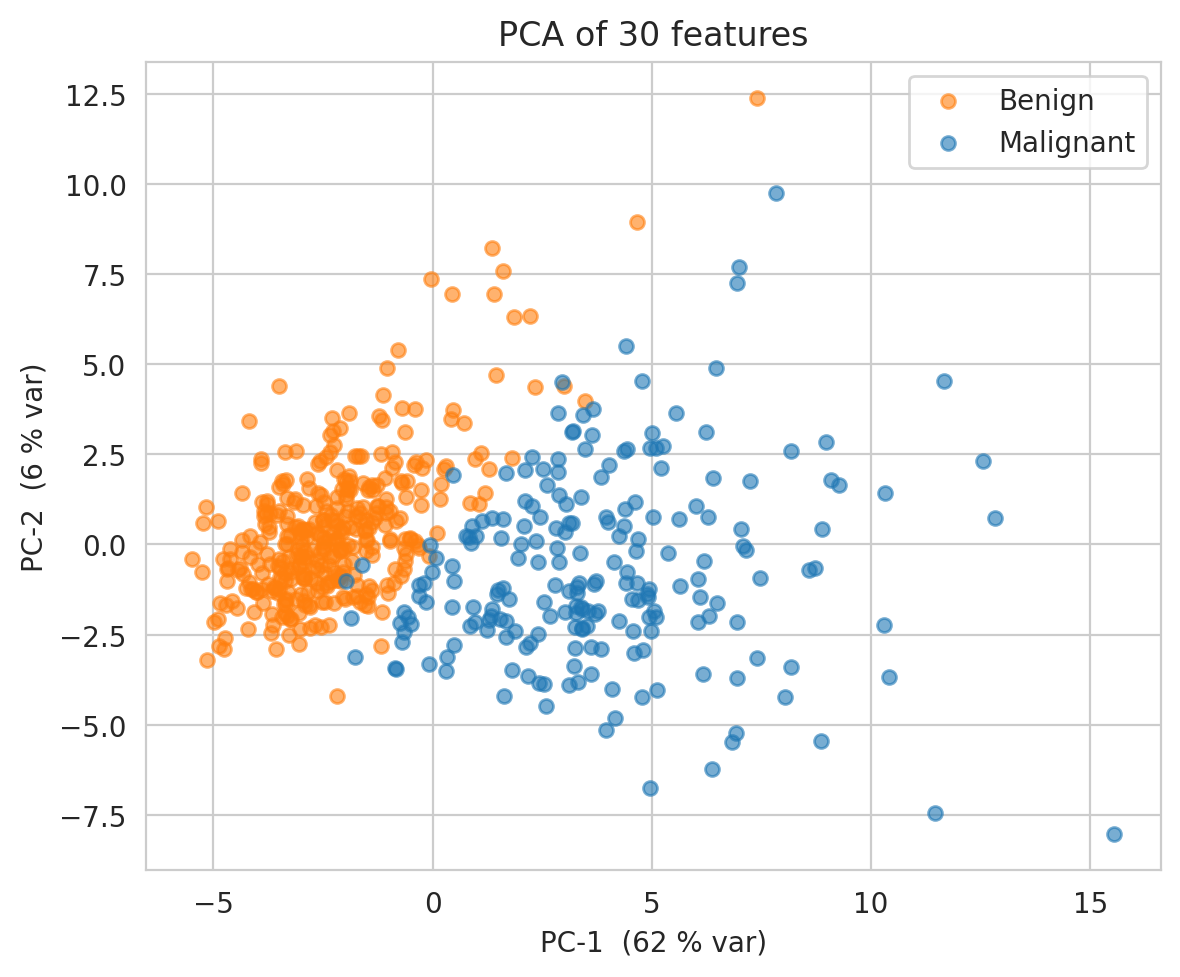

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(df.iloc[:,2:32])
pca      = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(pca[df.label==0,0], pca[df.label==0,1],
            alpha=.6, label='Benign', s=25, color='tab:orange')
plt.scatter(pca[df.label==1,0], pca[df.label==1,1],
            alpha=.6, label='Malignant', s=25, color='tab:blue')
plt.xlabel('PC-1  (62 % var)'); plt.ylabel('PC-2  (6 % var)')
plt.legend(); plt.title('PCA of 30 features'); plt.tight_layout(); plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Function
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp

#Prep Training Data (Breast Cancer Wisconsin)

#Load the data file
df = pd.read_csv("/content/FLIQ-Virtual-Hackathon/Sample Code/data/wdbc.data", header=None)

#Assign column names
columns = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
df.columns = columns

#Drop the ID column
df = df.drop(columns=['id'])

#Encode diagnosis: M = 1, B = 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

#Convert to numpy arrays
X = df.drop(columns=['diagnosis']).values.astype(np.float32)
Y = df['diagnosis'].values.astype(np.float32).reshape(-1, 1)

#Normalize features manually (z-score)
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

#Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

#Manual train/test split (80/20)
num_samples = X_tensor.shape[0]
indices = torch.randperm(num_samples)

split_idx = int(num_samples * 0.8)
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

X_train = X_tensor[train_indices]
Y_train = Y_tensor[train_indices]
X_test = X_tensor[test_indices]
Y_test = Y_tensor[test_indices]

#VQA Circuit
n_qubits = 2
params = ParameterVector('theta', length=4)

def create_vqa_circuit(input_data, weights):
    # input_data: 2-element vector coming from tanh-activated Linear layer
    theta0, theta1 = float(input_data[0]), float(input_data[1])
    qc = QuantumCircuit(2)

    # data re-uploading encoding
    qc.ry(theta0, 0)
    qc.ry(theta1, 1)
    qc.cx(0, 1)

    # trainable block
    qc.ry(float(weights[0]), 0)
    qc.rz(float(weights[1]), 0)
    qc.ry(float(weights[2]), 1)
    qc.rz(float(weights[3]), 1)
    return qc

#Qiskit StatevectorEstimator primitive
estimator = StatevectorEstimator()

observables = [SparsePauliOp("ZI")]

#PyTorch Custom Autograd Function For VQA Layer
class VQALayerFunction(Function):
    @staticmethod
    def forward(ctx, input_tensor, weights):
        input_vals = input_tensor.detach().numpy()
        weight_vals = weights.detach().numpy()
        ctx.save_for_backward(input_tensor, weights)

        qc = create_vqa_circuit(input_vals, weight_vals)
        job = estimator.run([(qc, observables)])
        expval = job.result()[0].data.evs

        return torch.tensor([expval], dtype=torch.float32)

    @staticmethod
    def backward(ctx, grad_output):
        input_tensor, weights = ctx.saved_tensors
        x      = input_tensor.detach().numpy()
        theta  = weights.detach().numpy()
        shift  = np.pi/2
        grads  = []

        for k in range(len(theta)):
            theta_p, theta_m = theta.copy(), theta.copy()
            theta_p[k] += shift;  theta_m[k] -= shift
            qc_p = create_vqa_circuit(x, theta_p)
            qc_m = create_vqa_circuit(x, theta_m)
            exp_p = estimator.run([(qc_p, observables)]).result()[0].data.evs
            exp_m = estimator.run([(qc_m, observables)]).result()[0].data.evs
            grads.append(0.5*(exp_p - exp_m))

        grads = torch.tensor(grads, dtype=torch.float32)
        return None, (grad_output.view(-1)[0] * grads).view(-1)

#Quantum Layer as PyTorch Module
class VQALayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(4)) #4 trainable parameters for the circuit

    def forward(self, x):
        return torch.stack([VQALayerFunction.apply(x[i], self.weights) for i in range(x.size(0))]).view(-1, 1)

#Full Hybrid Model
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.classical = nn.Linear(X_tensor.shape[1], 2) #Classic preprocessing layer
        self.quantum = VQALayer() #VQA layer
        self.output = nn.Linear(1, 1) #Final classical layer

    def forward(self, x):
        x = self.classical(x)
        x = torch.tanh(x)  #Activation before quantum layer
        x = self.quantum(x)
        x = self.output(x)
        return torch.sigmoid(x)

model = HybridModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.BCELoss()

#Training Loop
for epoch in range(50):
    optimizer.zero_grad()
    preds = model(X_train)
    loss = loss_fn(preds, Y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        acc = ((preds > 0.5).float() == Y_train).float().mean()
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Accuracy: {acc.item()*100:.2f}%")

#Implement Testing Loop:


<ipython-input-10-de5a0192f350>:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor([expval], dtype=torch.float32)


Epoch 1 | Loss: 0.6651 | Accuracy: 61.32%
Epoch 2 | Loss: 0.6619 | Accuracy: 61.32%
Epoch 3 | Loss: 0.6596 | Accuracy: 61.32%
Epoch 4 | Loss: 0.6575 | Accuracy: 61.32%
Epoch 5 | Loss: 0.6553 | Accuracy: 61.32%
Epoch 6 | Loss: 0.6530 | Accuracy: 61.32%
Epoch 7 | Loss: 0.6507 | Accuracy: 61.32%
Epoch 8 | Loss: 0.6488 | Accuracy: 61.32%
Epoch 9 | Loss: 0.6471 | Accuracy: 61.32%
Epoch 10 | Loss: 0.6456 | Accuracy: 61.54%
Epoch 11 | Loss: 0.6439 | Accuracy: 62.86%
Epoch 12 | Loss: 0.6423 | Accuracy: 63.74%
Epoch 13 | Loss: 0.6407 | Accuracy: 63.74%
Epoch 14 | Loss: 0.6394 | Accuracy: 63.74%
Epoch 15 | Loss: 0.6383 | Accuracy: 63.74%
Epoch 16 | Loss: 0.6372 | Accuracy: 63.08%
Epoch 17 | Loss: 0.6361 | Accuracy: 63.52%
Epoch 18 | Loss: 0.6351 | Accuracy: 63.96%
Epoch 19 | Loss: 0.6342 | Accuracy: 64.62%
Epoch 20 | Loss: 0.6335 | Accuracy: 64.40%
Epoch 21 | Loss: 0.6328 | Accuracy: 65.05%
Epoch 22 | Loss: 0.6322 | Accuracy: 64.18%
Epoch 23 | Loss: 0.6315 | Accuracy: 63.96%
Epoch 24 | Loss: 0.6

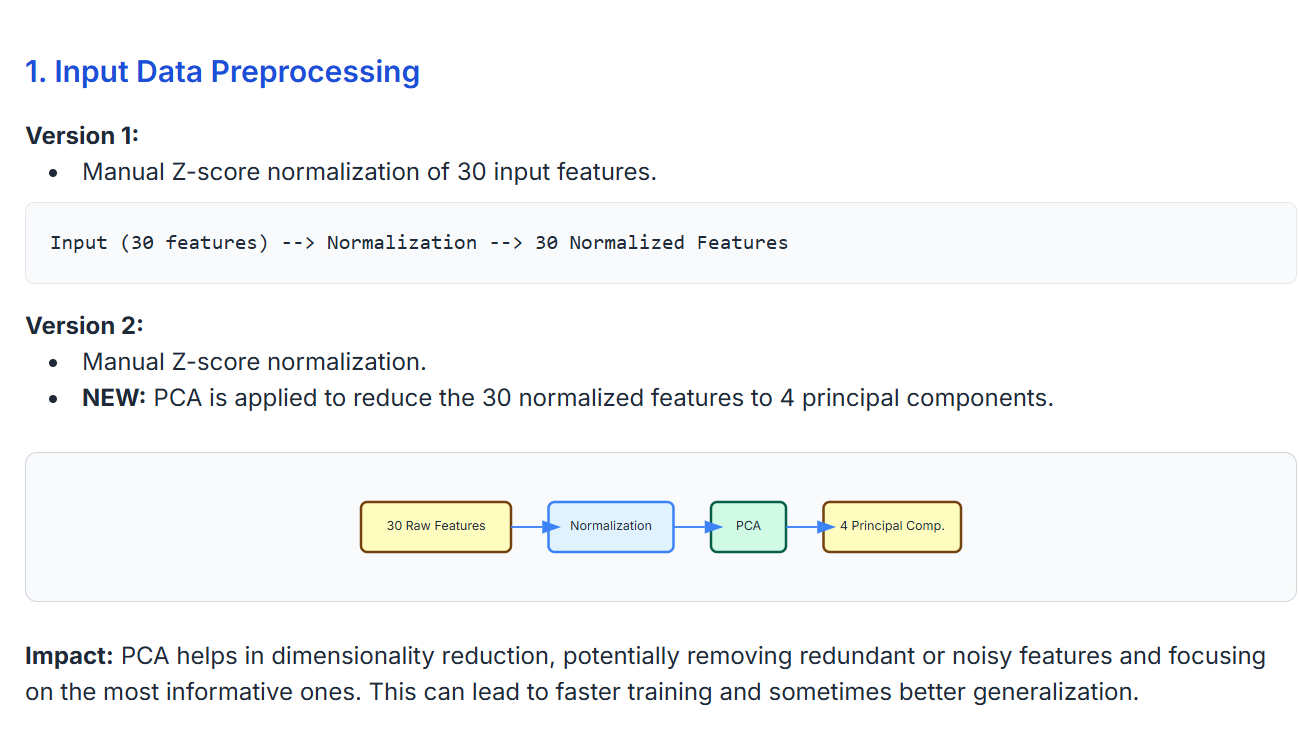

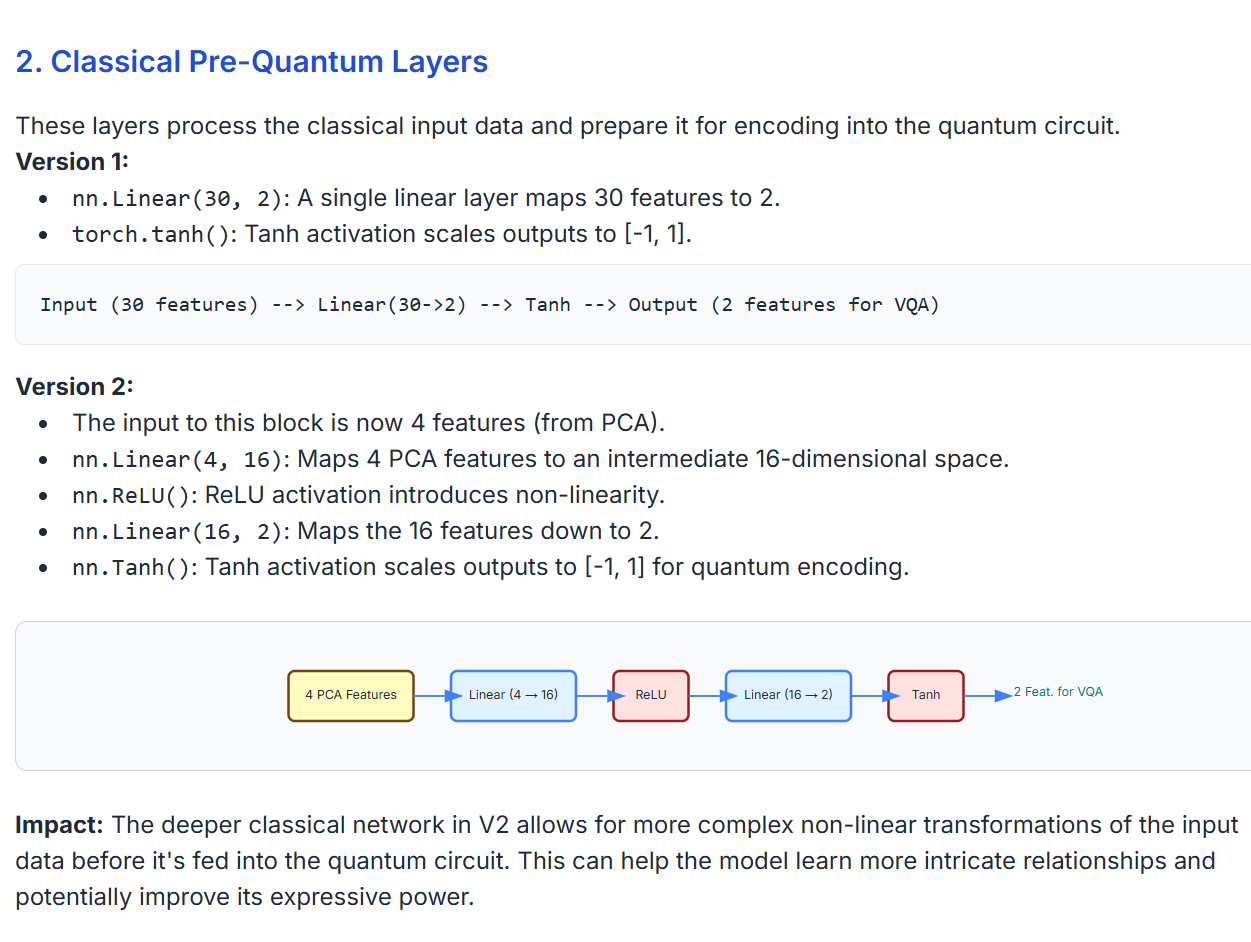

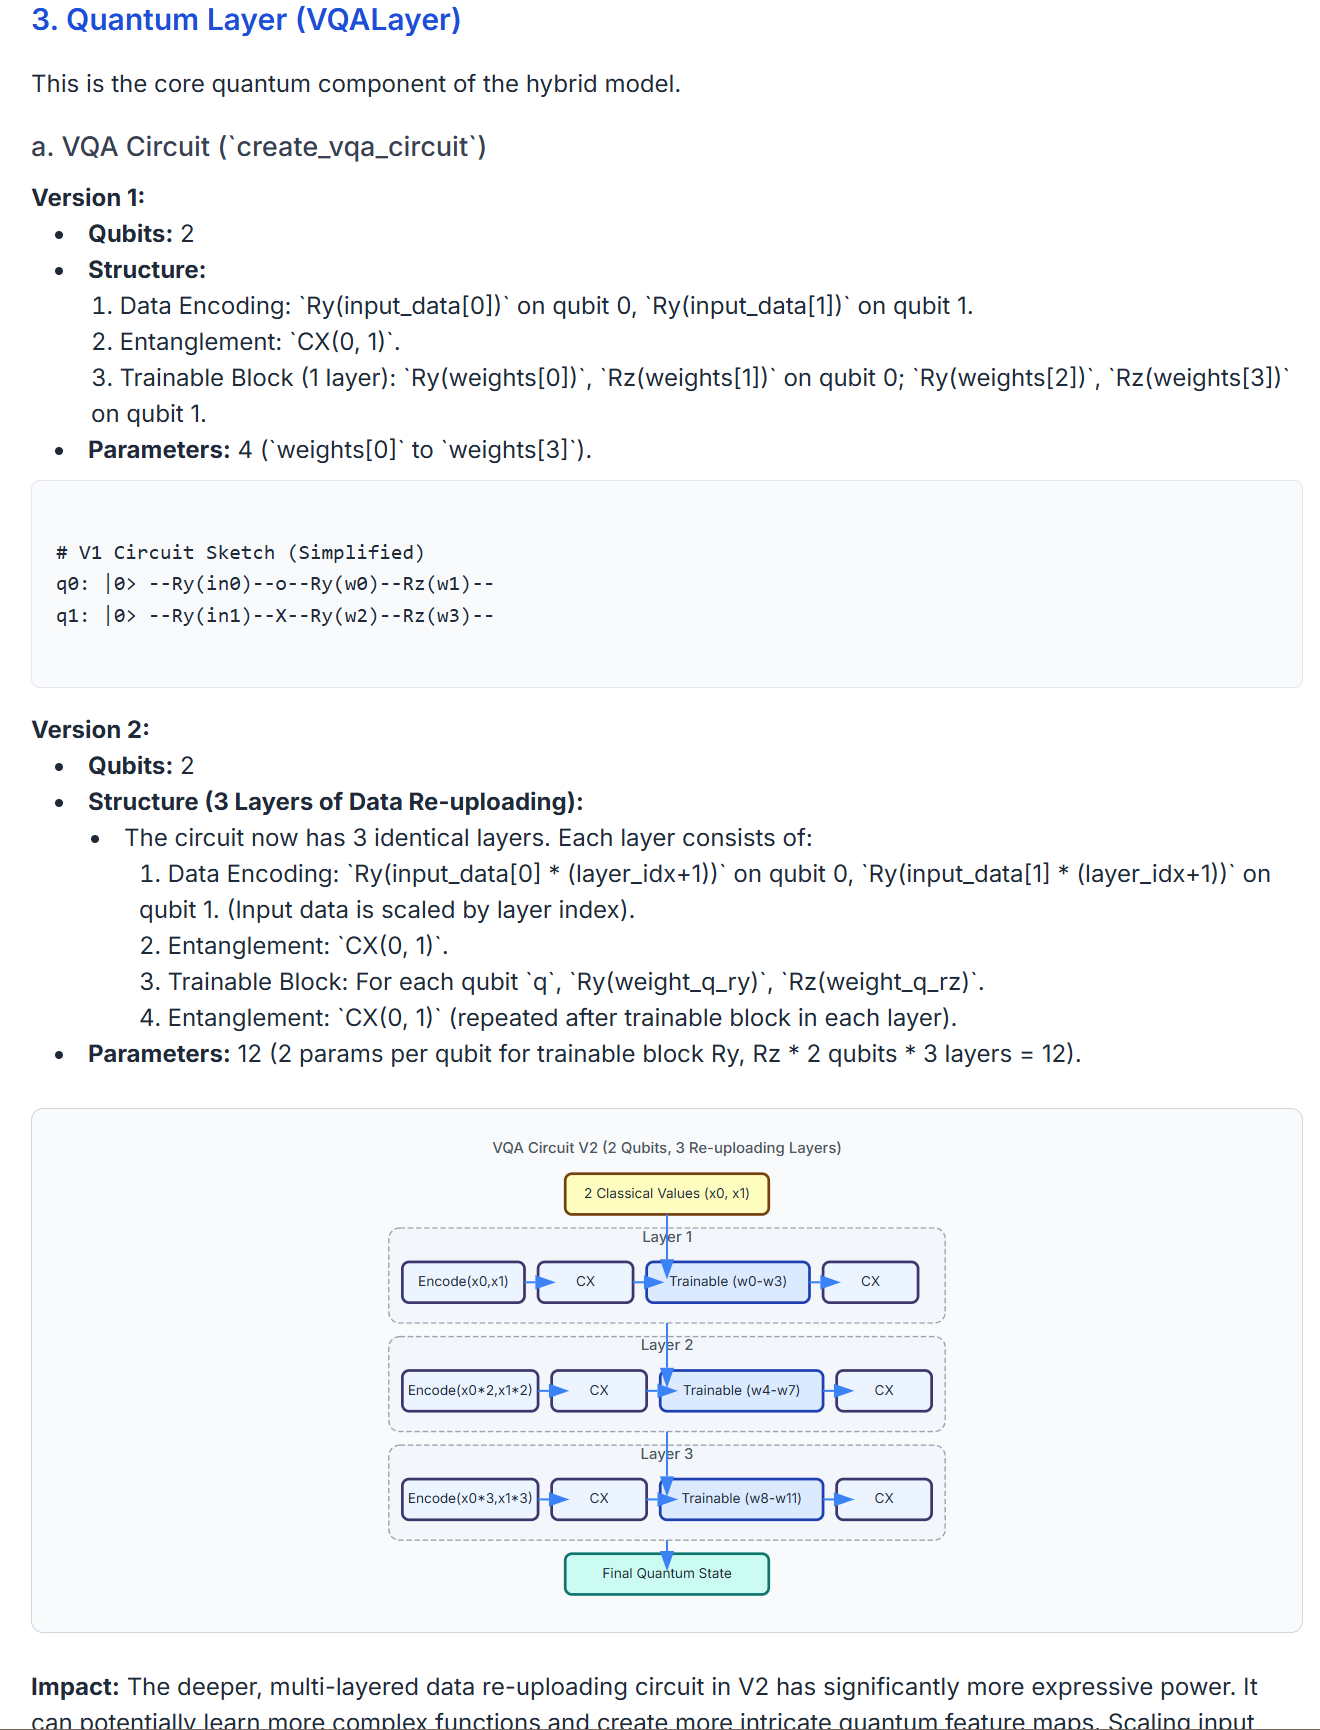
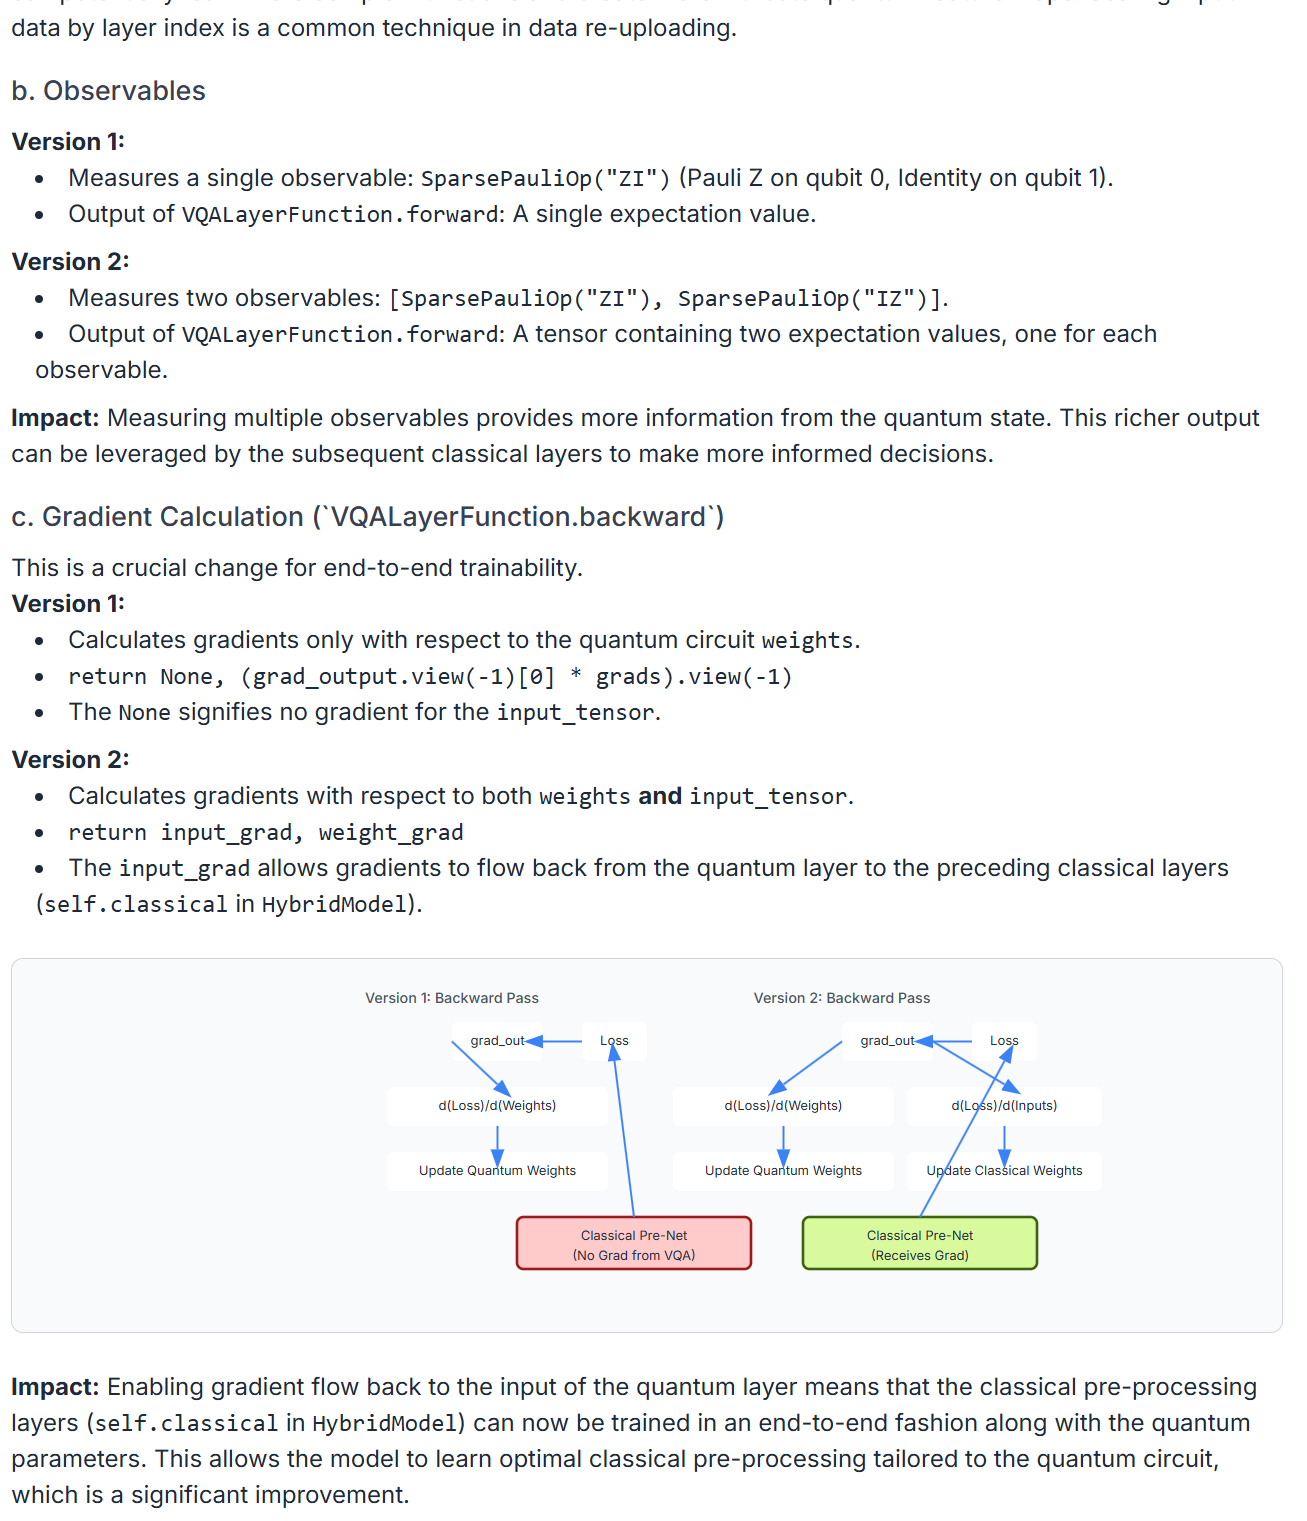


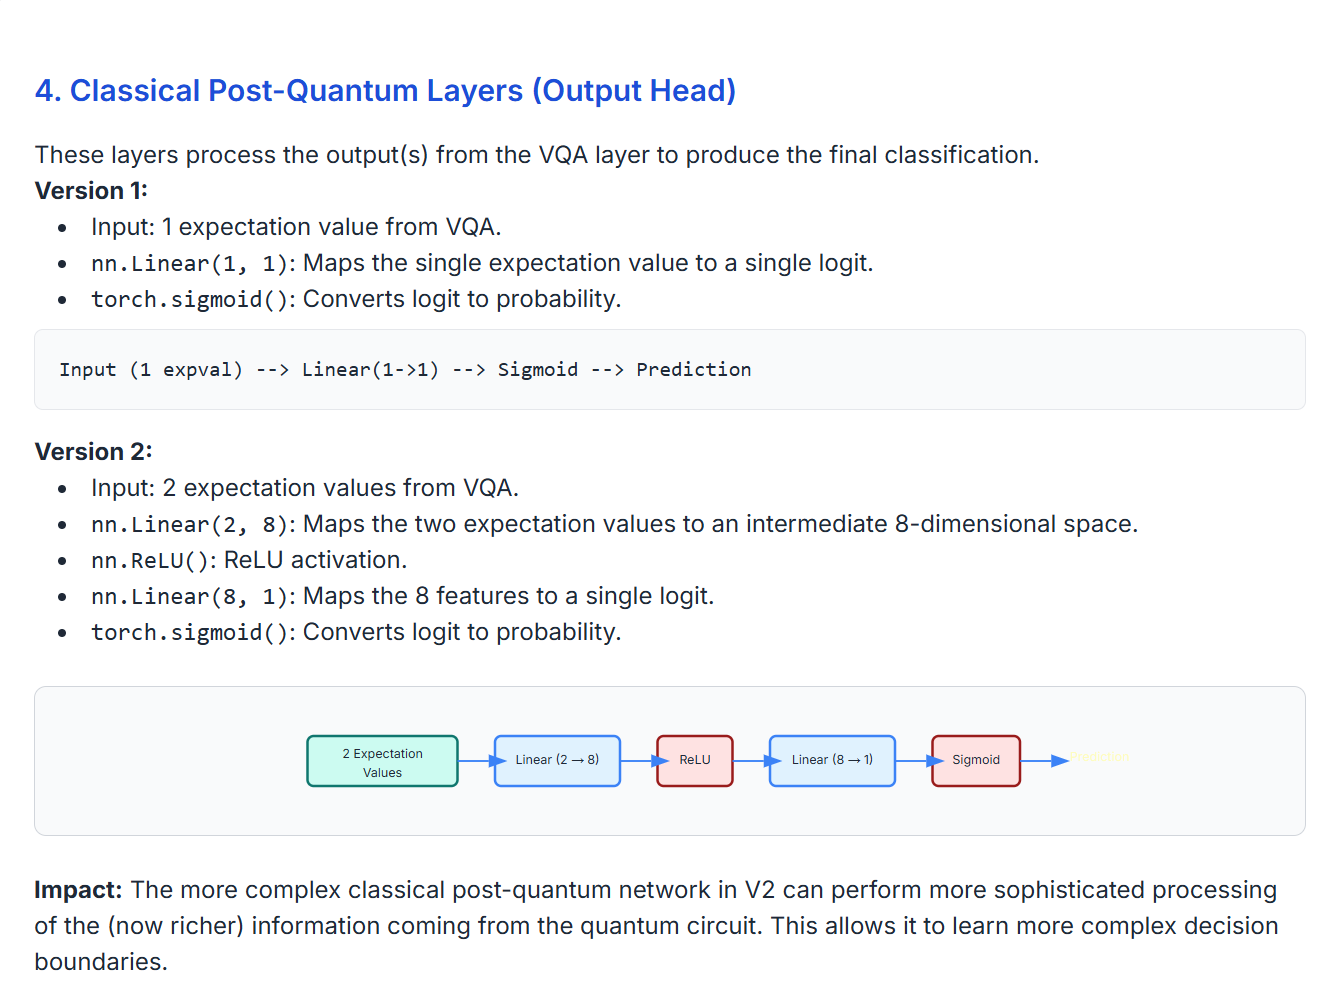

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Function
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Prep Training Data (Breast Cancer Wisconsin)

#Load the data file
df = pd.read_csv("/content/FLIQ-Virtual-Hackathon/Sample Code/data/wdbc.data", header=None)

#Assign column names
columns = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
df.columns = columns

#Drop the ID column
df = df.drop(columns=['id'])

#Encode diagnosis: M = 1, B = 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

#Convert to numpy arrays
X = df.drop(columns=['diagnosis']).values.astype(np.float32)
Y = df['diagnosis'].values.astype(np.float32).reshape(-1, 1)

#Normalize features manually (z-score)
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

# --- Feature reduction: keep first 4 principal components (retain >90% var) ---
X_pca = PCA(n_components=4).fit_transform(X)

#Convert to torch tensors (use PCA-reduced features)
X_tensor = torch.tensor(X_pca, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

#Manual train/test split (80/20)
num_samples = X_tensor.shape[0]
indices = torch.randperm(num_samples)

split_idx = int(num_samples * 0.8)
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

X_train = X_tensor[train_indices].to(device)
Y_train = Y_tensor[train_indices].to(device)
X_test = X_tensor[test_indices].to(device)
Y_test = Y_tensor[test_indices].to(device)

# ----- 2-qubit VQA (data-reuploading, 3 layers, 12 params) -----
n_qubits = 2
param_count = 12  # 2 qubits × 2 params (Ry,Rz) × 3 layers
params = ParameterVector('theta', length=param_count)

# Helper to add an entangling ring
_def_entangle = lambda qc: qc.cx(0, 1)

def create_vqa_circuit(input_data, weights):
    """2-qubit, 3-layer data-reuploading circuit."""
    qc = QuantumCircuit(n_qubits)
    idx = 0
    for layer in range(3):
        # encode data
        qc.ry(float(input_data[0]) * (layer+1), 0)
        qc.ry(float(input_data[1]) * (layer+1), 1)
        _def_entangle(qc)
        # trainable block
        for q in range(n_qubits):
            qc.ry(float(weights[idx]), q); idx += 1
            qc.rz(float(weights[idx]), q); idx += 1
        _def_entangle(qc)
    return qc

#Qiskit StatevectorEstimator primitive
estimator = StatevectorEstimator()

# Observables: Z expectation on each qubit
observables = [SparsePauliOp("ZI"), SparsePauliOp("IZ")]

#PyTorch Custom Autograd Function For VQA Layer
class VQALayerFunction(Function):
    @staticmethod
    def forward(ctx, input_tensor, weights):
        # input_tensor shape (4,), weights shape (12,)
        input_vals  = input_tensor.cpu().detach().numpy()
        weight_vals = weights.cpu().detach().numpy()
        ctx.save_for_backward(input_tensor, weights)

        qc = create_vqa_circuit(input_vals, weight_vals)
        circuits = [(qc, obs) for obs in observables]
        res = estimator.run(circuits).result()
        expvals = np.array([r.data.evs for r in res])  # shape (4,)
        return torch.tensor(expvals, dtype=torch.float32).to(input_tensor.device)

    @staticmethod
    def backward(ctx, grad_output):
        input_tensor, weights = ctx.saved_tensors
        x      = input_tensor.cpu().detach().numpy()
        theta  = weights.cpu().detach().numpy()
        shift  = np.pi/2
        # gradients wrt weights
        grad_w = []
        for k in range(len(theta)):
            theta_p, theta_m = theta.copy(), theta.copy()
            theta_p[k] += shift; theta_m[k] -= shift
            qc_p = create_vqa_circuit(x, theta_p)
            qc_m = create_vqa_circuit(x, theta_m)
            res_p = estimator.run([(qc_p, obs) for obs in observables]).result()
            res_m = estimator.run([(qc_m, obs) for obs in observables]).result()
            grad_w.append(0.5 * (np.array([r.data.evs for r in res_p]) -
                                  np.array([r.data.evs for r in res_m])))
        grad_w = torch.tensor(grad_w, dtype=torch.float32).to(grad_output.device)  # (P,2)
        weight_grad = torch.mv(grad_w, grad_output.view(-1))  # (P,)

        # gradients wrt inputs (allow classical NN to train)
        grad_x = []
        for j in range(len(x)):
            x_p, x_m = x.copy(), x.copy()
            x_p[j] += shift; x_m[j] -= shift
            qc_p = create_vqa_circuit(x_p, theta)
            qc_m = create_vqa_circuit(x_m, theta)
            res_p = estimator.run([(qc_p, obs) for obs in observables]).result()
            res_m = estimator.run([(qc_m, obs) for obs in observables]).result()
            grad_x.append(0.5 * (np.array([r.data.evs for r in res_p]) -
                                  np.array([r.data.evs for r in res_m])))
        grad_x = torch.tensor(grad_x, dtype=torch.float32).to(grad_output.device)  # (2,2)
        input_grad = torch.mv(grad_x, grad_output.view(-1))  # (features,)

        return input_grad, weight_grad

#Quantum Layer as PyTorch Module
class VQALayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(param_count, device=device))

    def forward(self, x):
        # x shape (batch,2)
        outputs = [VQALayerFunction.apply(x[i], self.weights) for i in range(x.size(0))]
        return torch.stack(outputs)  # (batch,2)

#Full Hybrid Model
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.classical = nn.Sequential(
            nn.Linear(X_tensor.shape[1], 16),
            nn.ReLU(),
            nn.Linear(16, 2),  # output matches qubit count
            nn.Tanh()
        )
        self.quantum = VQALayer()
        self.output = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.classical(x)
        x = self.quantum(x)
        x = self.output(x)
        return x

model = HybridModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.BCELoss()

#Training Loop
for epoch in range(50):
    optimizer.zero_grad()
    preds = model(X_train)
    loss = loss_fn(preds, Y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        acc = ((preds > 0.5).float() == Y_train).float().mean()
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Accuracy: {acc.item()*100:.2f}%")

#Implement Testing Loop:
with torch.no_grad():
    test_preds = model(X_test)
    test_labels_on_device = (test_preds > 0.5).float()
    test_acc = (test_labels_on_device == Y_test).float().mean().item()
    print("\nTest Accuracy: {:.2f}%".format(test_acc*100))
    print("\nClassification Report:\n", classification_report(Y_test.cpu().numpy(), test_labels_on_device.cpu().numpy()))
    print("Confusion Matrix:\n", confusion_matrix(Y_test.cpu().numpy(), test_labels_on_device.cpu().numpy()))

# Save the trained model
model_save_path = "model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"\nTrained model saved to: {model_save_path}")



Using device: cpu


<ipython-input-4-6ef0828f119a>:123: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  grad_w = torch.tensor(grad_w, dtype=torch.float32).to(grad_output.device)  # (P,2)


Epoch 1 | Loss: 0.7179 | Accuracy: 36.48%
Epoch 2 | Loss: 0.7172 | Accuracy: 36.48%
Epoch 3 | Loss: 0.7165 | Accuracy: 36.48%
Epoch 4 | Loss: 0.7158 | Accuracy: 36.48%
Epoch 5 | Loss: 0.7151 | Accuracy: 36.48%
Epoch 6 | Loss: 0.7143 | Accuracy: 36.48%
Epoch 7 | Loss: 0.7136 | Accuracy: 36.48%
Epoch 8 | Loss: 0.7128 | Accuracy: 36.48%
Epoch 9 | Loss: 0.7120 | Accuracy: 36.48%
Epoch 10 | Loss: 0.7112 | Accuracy: 36.48%
Epoch 11 | Loss: 0.7103 | Accuracy: 36.48%
Epoch 12 | Loss: 0.7094 | Accuracy: 36.48%
Epoch 13 | Loss: 0.7086 | Accuracy: 36.48%
Epoch 14 | Loss: 0.7076 | Accuracy: 36.48%
Epoch 15 | Loss: 0.7067 | Accuracy: 36.48%
Epoch 16 | Loss: 0.7058 | Accuracy: 36.48%
Epoch 17 | Loss: 0.7048 | Accuracy: 36.48%
Epoch 18 | Loss: 0.7038 | Accuracy: 36.48%
Epoch 19 | Loss: 0.7028 | Accuracy: 36.48%
Epoch 20 | Loss: 0.7018 | Accuracy: 36.48%
Epoch 21 | Loss: 0.7008 | Accuracy: 36.48%
Epoch 22 | Loss: 0.6998 | Accuracy: 36.70%
Epoch 23 | Loss: 0.6989 | Accuracy: 36.26%
Epoch 24 | Loss: 0.6

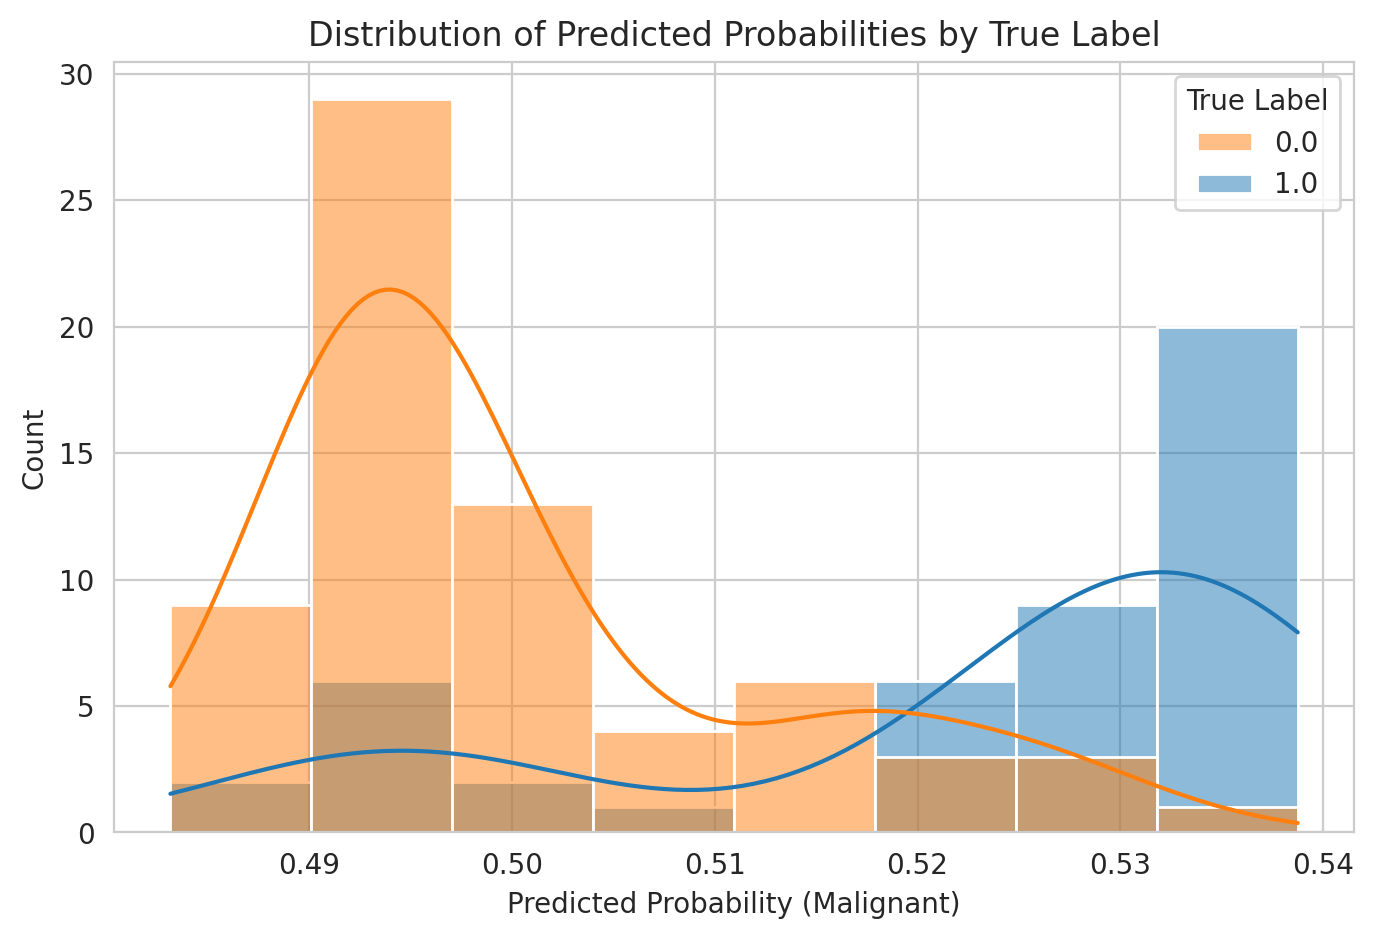

In [ ]:
# Add diagnosis labels to the predicted probabilities for visualization
test_results = pd.DataFrame({
    'Predicted Probability': test_preds.detach().numpy().flatten(),
    'True Label': Y_test.numpy().flatten()
})

plt.figure(figsize=(8, 5))
sns.histplot(data=test_results, x='Predicted Probability', hue='True Label',
             kde=True, palette=['tab:orange', 'tab:blue'])
plt.title('Distribution of Predicted Probabilities by True Label')
plt.xlabel('Predicted Probability (Malignant)')
plt.show()

In [ ]:
# Get the predicted probabilities for the test set
test_preds = model(X_test)

# Convert predicted probabilities and true labels to numpy arrays
test_probs_np = test_preds.detach().numpy().flatten()
Y_test_np = Y_test.numpy().flatten()





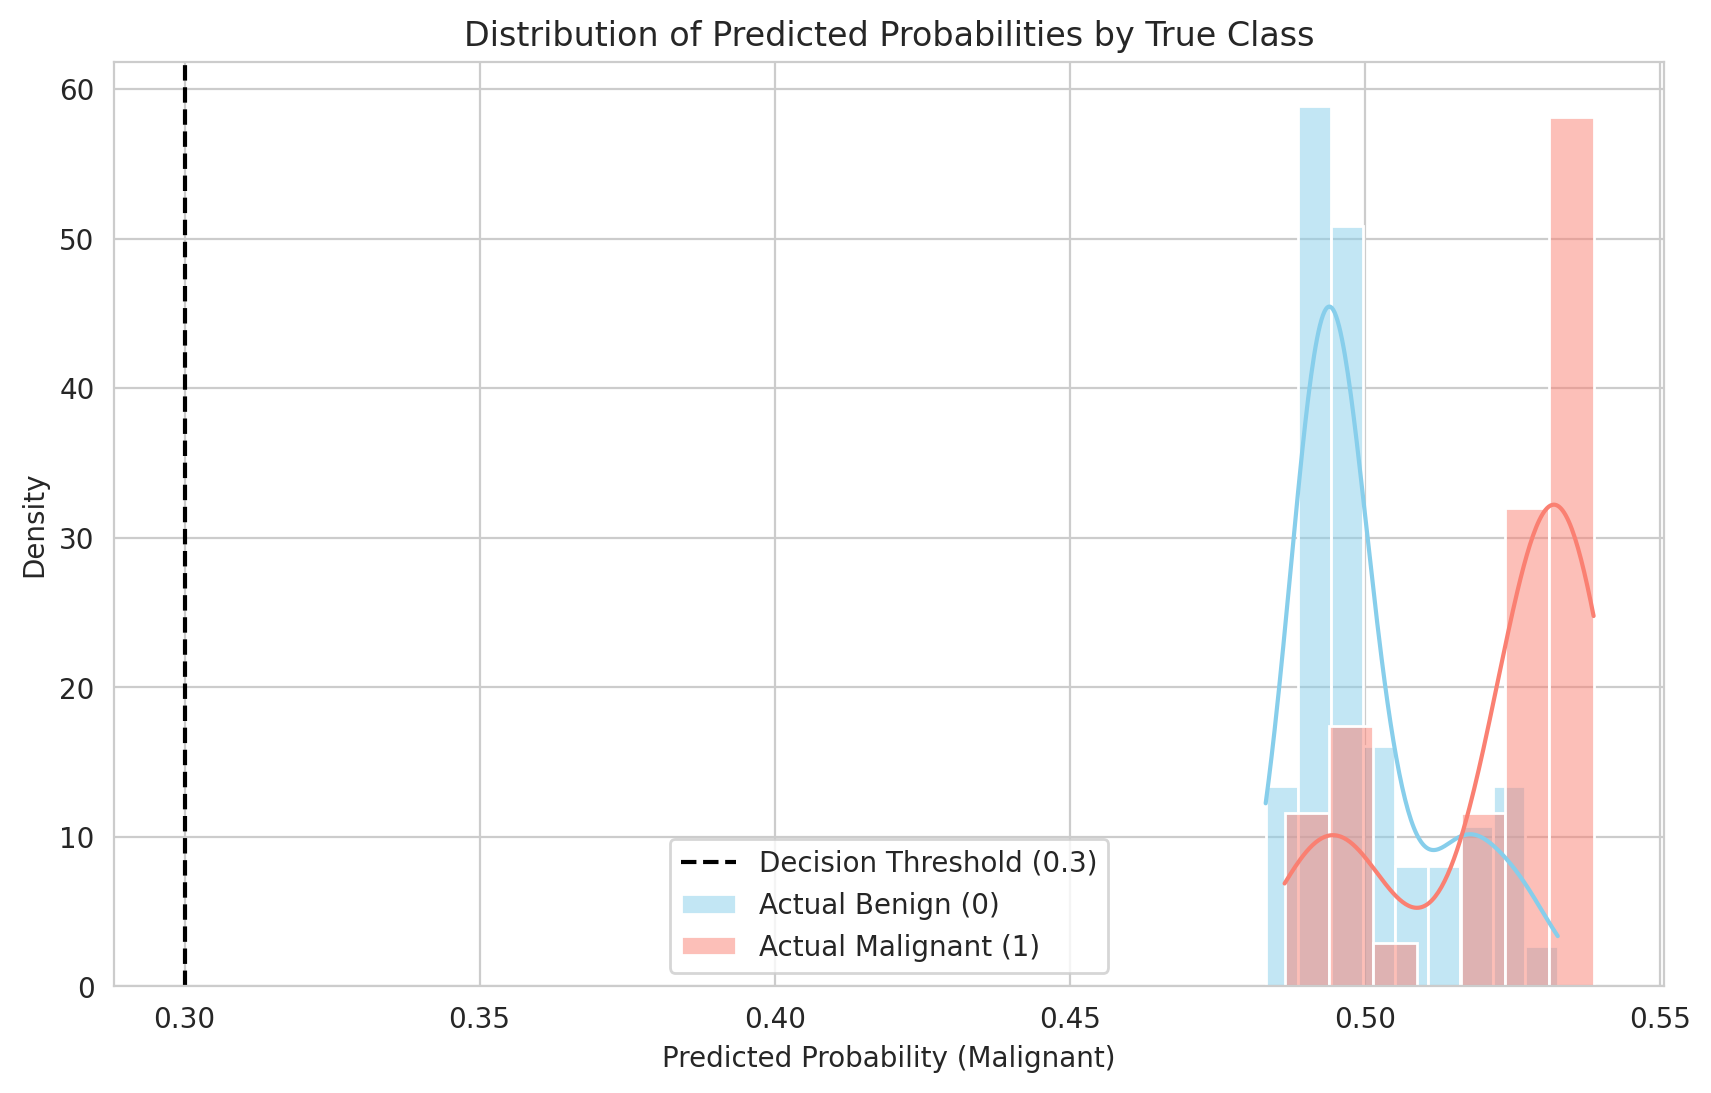

In [ ]:
# 1. Distribution of Predicted Probabilities
plt.figure(figsize=(10, 6))
sns.histplot(test_probs_np[Y_test_np == 0], color="skyblue", label="Actual Benign (0)", kde=True, stat="density", common_norm=False)
sns.histplot(test_probs_np[Y_test_np == 1], color="salmon", label="Actual Malignant (1)", kde=True, stat="density", common_norm=False)
plt.axvline(0.3, color='black', linestyle='--', label="Decision Threshold (0.3)")
plt.title('Distribution of Predicted Probabilities by True Class')
plt.xlabel('Predicted Probability (Malignant)')
plt.ylabel('Density')
plt.legend()
plt.show()

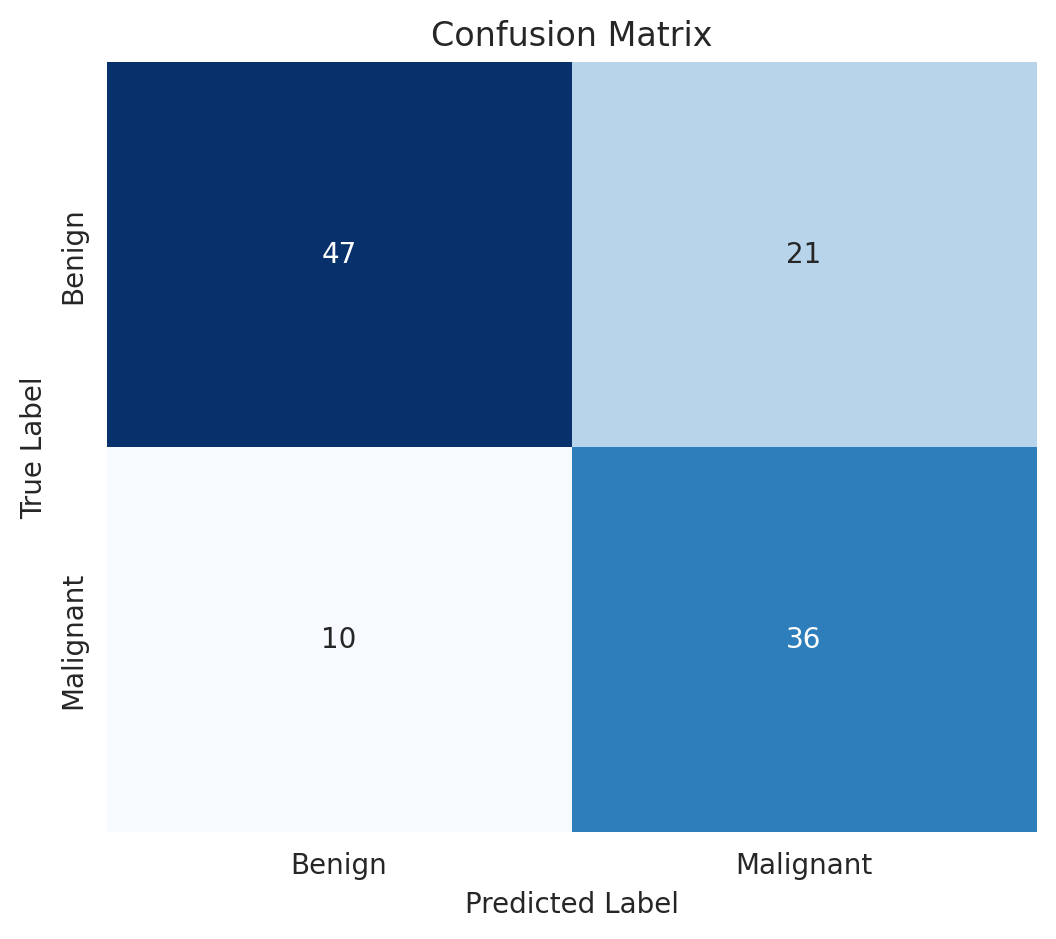

In [ ]:
# 2. Confusion Matrix (using the defined variables)
from sklearn.metrics import confusion_matrix

# Get the binary predictions using the defined test_probs_np
test_preds_binary = (test_probs_np > 0.5).astype(int) # Assuming a default threshold of 0.5 for confusion matrix

# Create the confusion matrix
cm = confusion_matrix(Y_test_np, test_preds_binary)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

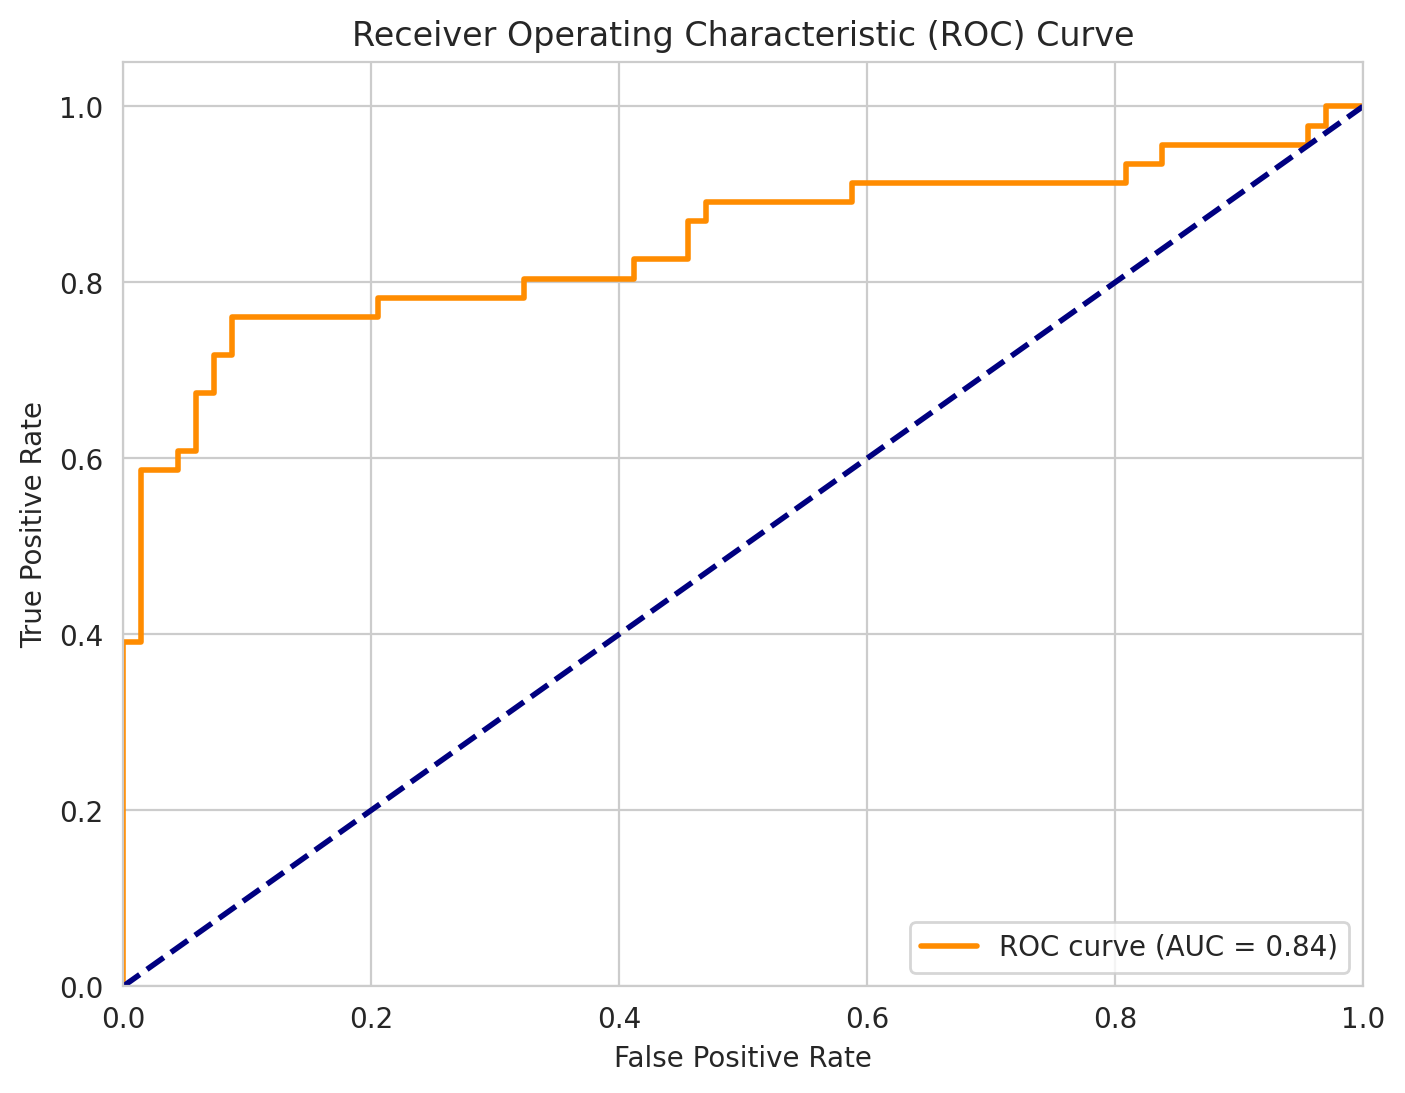

In [ ]:

# 3. ROC Curve (using the defined variables)
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_np, test_probs_np)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()